# Regents-races data exploration

In [221]:
import pandas as pd
import numpy as np

import scipy.stats as stats
from scipy.optimize import curve_fit

import seaborn as sns
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

sns.set(font_scale=1.5)

In [5]:
df = pd.read_csv('data/race_results', index_col=0)

In [6]:
df.head(3)

,Year,Race,Place,Name,Bib No,Gun Time,Net Time,Category,Categ Pos,Gender,Gender Pos,Club,Lap 1 Time,Lap 2 Time,Lap 3 Time
0,2011,0,1,Richard Scott,2042,32.633333,NaN,Senior,1,Male,1,Highgate Harriers,NaN,NaN,NaN
1,2011,0,2,Hassan Raini,2044,33.200000,NaN,Senior,2,Male,2,Belgrave Harriers,NaN,NaN,NaN
2,2011,0,3,Jonathan Stead,823,33.500000,NaN,Senior,3,Male,3,Herne Hill Harriers,NaN,NaN,NaN


## Race participation

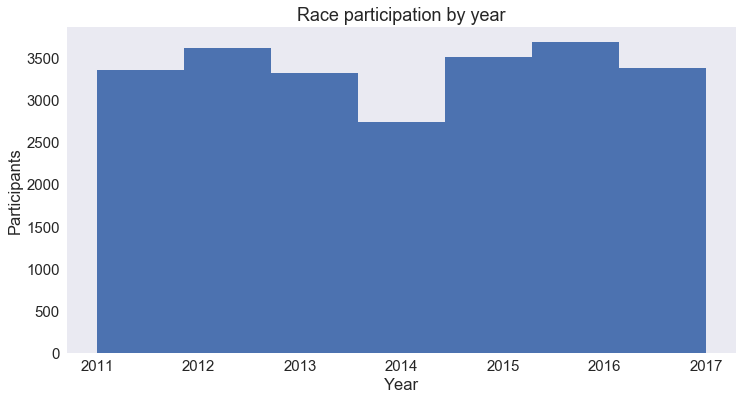

In [7]:
plt.figure(figsize=(12,6))
df['Year'].hist(grid=False,bins=7)
plt.title('Race participation by year')
plt.ylabel('Participants')
plt.xlabel('Year')

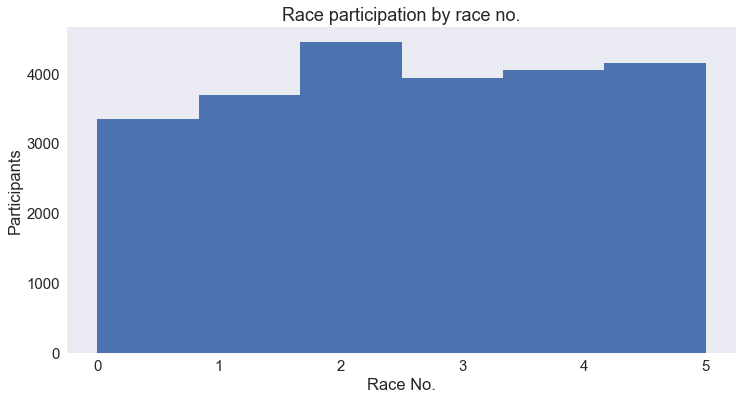

In [8]:
plt.figure(figsize=(12,6))
df['Race'].hist(grid=False,bins=6)
plt.title('Race participation by race no.')
plt.ylabel('Participants')
plt.xlabel('Race No.')

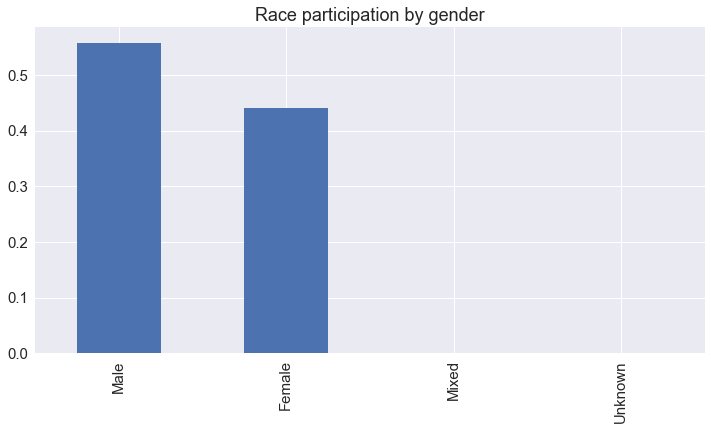

In [9]:
plt.figure(figsize=(12,6))
df['Gender'].value_counts(normalize=True).plot(kind='bar')
plt.title('Race participation by gender')

## Race times

In [10]:
# Only use races with chip timing
df2 = df[np.isfinite(df['Net Time'])]
df2 = df2[df2['Net Time'] > 0 ]
df2 = df2[df2['Net Time'] < 1000]
df2.shape

(22677, 15)

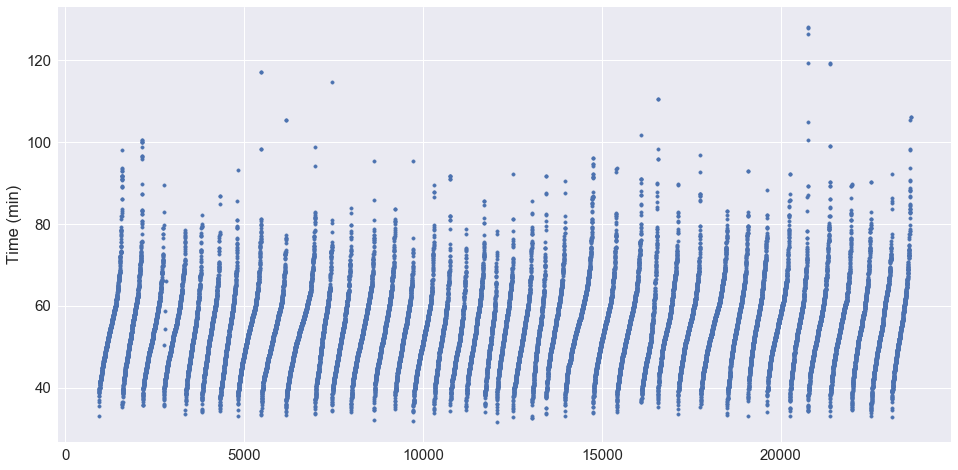

In [11]:
plt.figure(figsize=(16,8))
plt.scatter(df2.index, df2['Gun Time'],marker='.')
plt.ylabel('Time (min)')

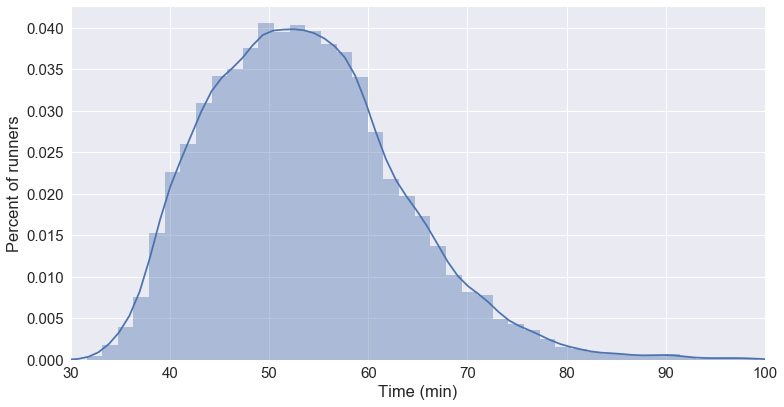

In [12]:
fg = sns.FacetGrid(data=df2, aspect=1.8, size=6)
fg.map(sns.distplot, 'Net Time', bins = 60)

plt.ylabel('Percent of runners')
plt.xlabel('Time (min)')
plt.xlim([30,100])
plt.savefig('plots/time_distribution.png')

In [13]:
c = 'Gender'
gender_to_keep = df2[c].value_counts()[df2[c].value_counts() > 5]
to_keep   = df2[c].isin(gender_to_keep.index)
df2[c] = df2[to_keep][c]

(30, 95)

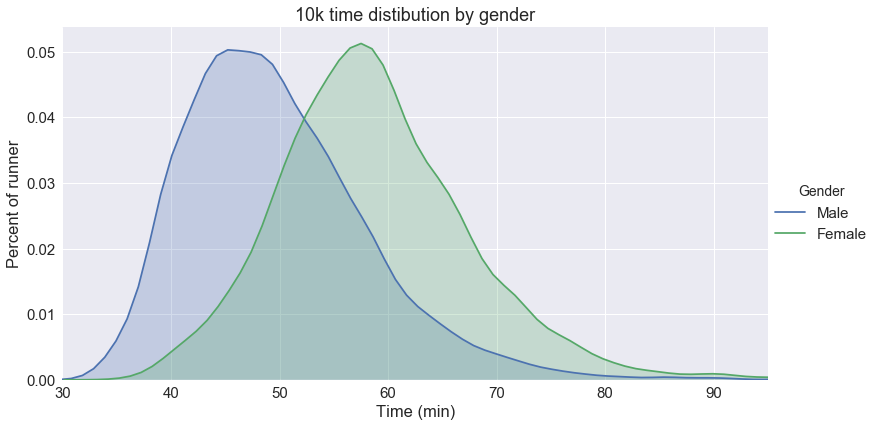

In [14]:
fg = sns.FacetGrid(data=df2, hue="Gender", aspect=1.8, size=6)
fg.map(sns.kdeplot, 'Net Time', shade=True)
fg.set(ylabel='Percent of runner')
fg.add_legend()
plt.savefig('plots/time_distribution_by_gender.png')
plt.xlabel('Time (min)')
plt.title('10k time distibution by gender')
plt.xlim([30,95])

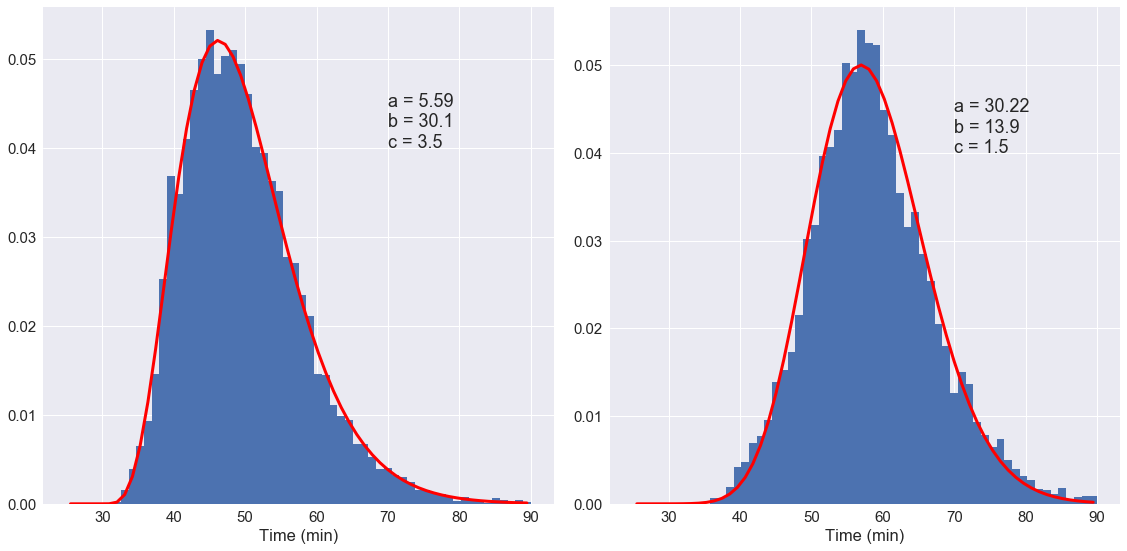

In [15]:
fig = plt.figure(figsize=(16,8))

gender = ['Male','Female']

for i,g in enumerate(gender):
    ax = fig.add_subplot(1,2,i+1) 

    n, bins, patches = plt.hist(x = df2[df2['Gender']==g]['Net Time'],
                                range = (25,90), normed=True, bins= 60)

    bin_centers = bins[:-1] + 0.5 * (bins[1:] - bins[:-1])

    popt, pcov = curve_fit(stats.gamma.pdf, bin_centers, n, p0 = [1, 50, 10])
    plt.plot(bin_centers, stats.gamma.pdf(bin_centers, *popt), 'r-', linewidth=3)
    
    stats.gamma(popt[0])
    
    
    plt.text(70, 0.04, 'a = {}\nb = {}\nc = {}'.format( round(popt[0],2), round(popt[1],1), round(popt[2],1) ))
    
    
    
        #    style='italic', transform=ax.transAxes, fontsize = 12, family='fantasy',
        #    bbox={'facecolor':'tomato', 'alpha':0.8, 'pad':5})
    
    plt.xlabel('Time (min)')
    
plt.tight_layout()

## Start delay

In [19]:
# Create delay column
df2['Delay'] = df2['Gun Time'] - df2['Net Time']

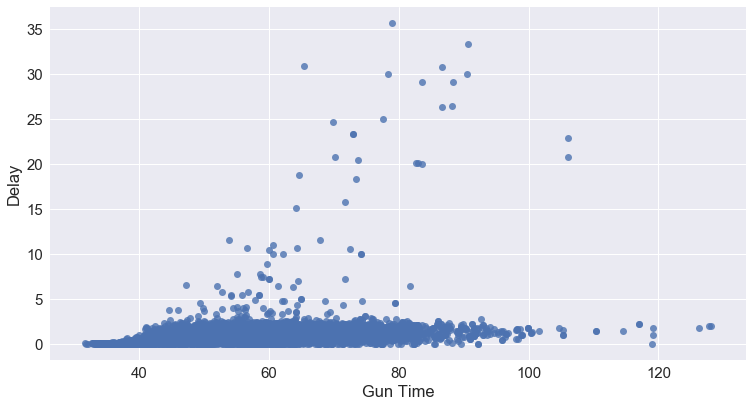

In [27]:
g = sns.lmplot(x="Gun Time", y="Delay", data=df2,
               fit_reg=False,
               aspect=1.8, size=6)

plt.savefig('plots/delay_by_time.png')

In [37]:
# There are some outliers.
# These are presumably late starters, who only arrived to 
# the race late
# We will take a somewhat arbitary cut of 3 mins.
# (there might be a better way of doing this?)

df3 = df2[df2['Delay'] < 3.0]


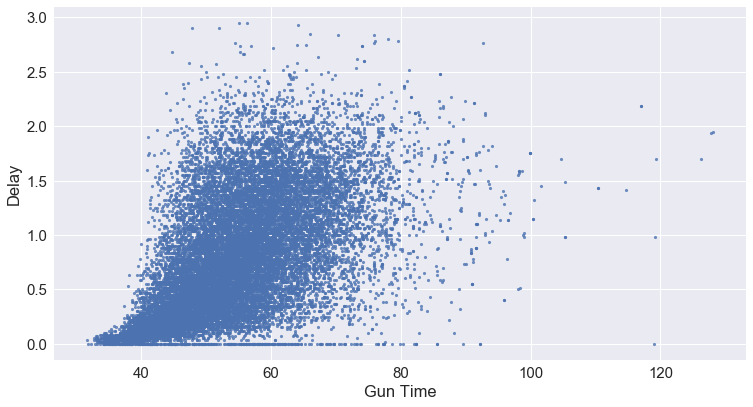

In [41]:
g = sns.lmplot(x="Gun Time", y="Delay", data=df3,
               fit_reg=False,
               scatter_kws={"marker": "D", "s": 10},
               aspect=1.8, size=6)

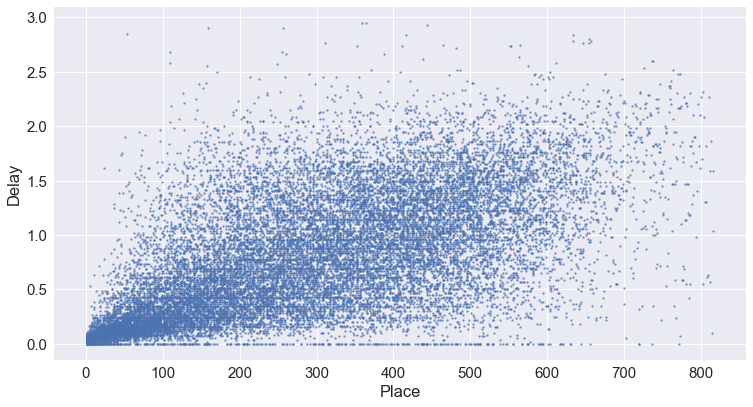

In [45]:
g = sns.lmplot(x="Place", y="Delay", data=df3,
               fit_reg=False,
               scatter_kws={"marker": "D", "s": 5},
               aspect=1.8, size=6)

plt.savefig('plots/delay_by_place.png')

In [44]:
# line of people at 0 delay?

d3 = df2[df2['Delay'] < 0.01]
d3 = d3[d3['Place'] > 100]

print(d3.Year.value_counts())
print(d3.Race.value_counts())

2017    53
2016    51
2012    43
2014    29
2013    25
2011    24
2015    19
Name: Year, dtype: int64
4    71
2    40
1    37
5    36
0    31
3    29
Name: Race, dtype: int64


## Lap times

In [48]:
df3 = df2[df2['Lap 1 Time'] > 10]
df3 = df3[df3['Lap 2 Time'] > 10]

is_cumulative = (df3['Lap 1 Time']+df3['Lap 2 Time']+df3['Lap 3 Time']-df3['Delay']) > 1.1*df3['Net Time']

df3 = df3[-is_cumulative]

In [60]:
#d1 = df3[df3['Delay'] > 10]
#d1['Lap 2 Time'] - (d1['Lap 1 Time']-d1['Delay'])

In [59]:
# are lap times are gunned!

#df3['Lap 1 Time'],df3['Lap 2 Time']-df3['Lap 1 Time']

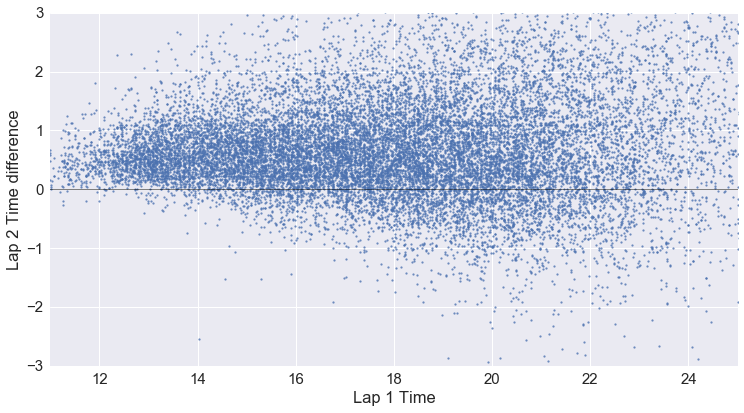

In [76]:
df3['Lap 2 Time difference'] = df3['Lap 2 Time'] - df3['Lap 1 Time'] + df3['Delay']

                                                  
g = sns.lmplot(x='Lap 1 Time', y = 'Lap 2 Time difference', data=df3,
               fit_reg=False,
               scatter_kws={"marker": "D", "s": 5},
               aspect=1.8, size=6)
plt.plot([0,500],[0]*2,color='k',linewidth=0.5)
plt.ylim([-3, 3])
plt.xlim([11, 25])
plt.savefig('plots/lap12_timediff.png')

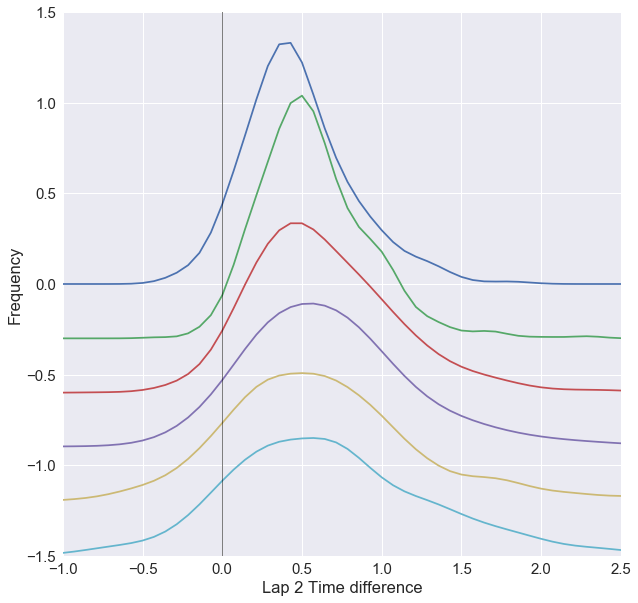

In [256]:
# 2d plotting of timeslices

fig = plt.figure(figsize=(10,10))
x = np.linspace(-1,2.5,50)


for i in range(6):
    time_slice = (df3['Lap 1 Time'] > 11+i) & (df3['Lap 1 Time'] < 12+i)
    d = df3[time_slice]
    s = d['Lap 2 Time difference']

    gkde = stats.gaussian_kde(s.values)
    y = gkde.evaluate(x)
    plt.plot(x, y - 0.3*i)

plt.plot([0,0],[-2, 2],'k',linewidth=0.5)
plt.ylim([-1.5,1.5])
plt.xlim([x[0],x[-1]])

plt.xlabel('Lap 2 Time difference')
plt.ylabel('Frequency')

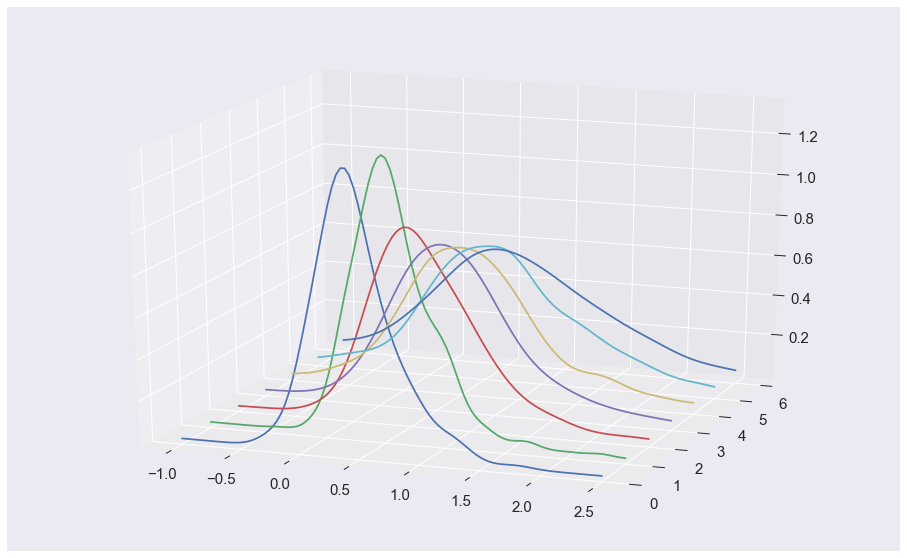

In [237]:
# 3d plotting of timeslices
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111, projection='3d')
x = np.linspace(-1,2.5,100)

for i in range(7):
    time_slice = (df3['Lap 1 Time'] > 11+i) & (df3['Lap 1 Time'] < 12+i)
    d = df3[time_slice]
    s = d['Lap 2 Time difference']

    gkde = stats.gaussian_kde(s.values)
    y = gkde.evaluate(x)
    ax.plot(x, i+0*y, y, zdir='z')

#ax.set_xlim([-1,3])
ax.view_init(elev=20, azim=-70)


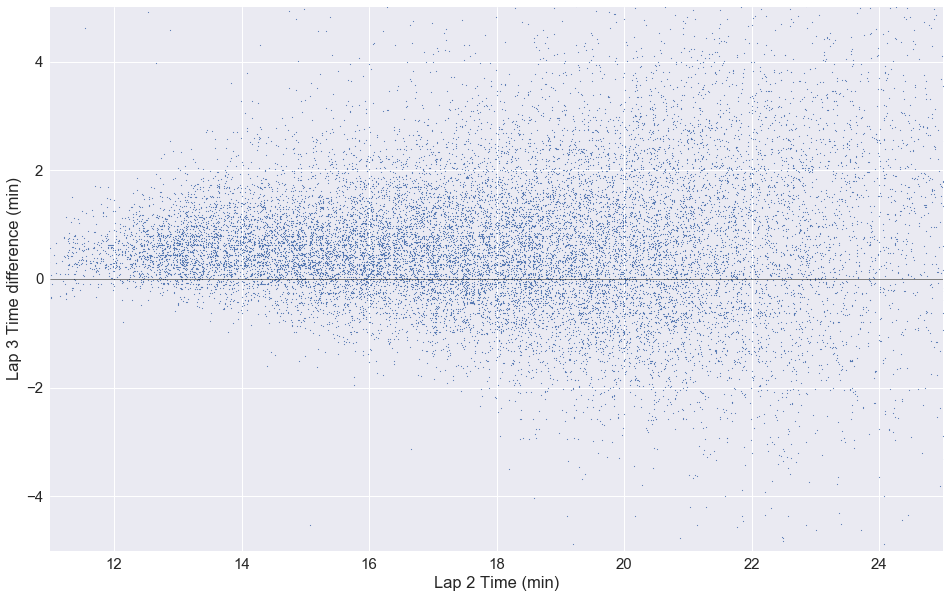

In [60]:
plt.figure(figsize=(16,10))

#plt.scatter(df3['Place'],df3['Lap 1 Time']-df3['Lap 2 Time'],marker='.',s=3)
plt.scatter(df3['Lap 1 Time'],df3['Lap 3 Time']-(df3['Lap 1 Time']-df3['Start delay']),marker='.',s=3)
#plt.hexbin(df3['Lap 1 Time'],df3['Lap 2 Time']-df3['Lap 1 Time'],gridsize=100)
plt.plot([11,25],[0]*2,color='k',linewidth=0.5)
plt.xlabel('Lap 2 Time (min)')
plt.ylabel('Lap 3 Time difference (min)')
plt.xlim([11, 25])
plt.ylim([-5, 5])
plt.savefig('plots/lap23_timediff.png')

## Seasonality

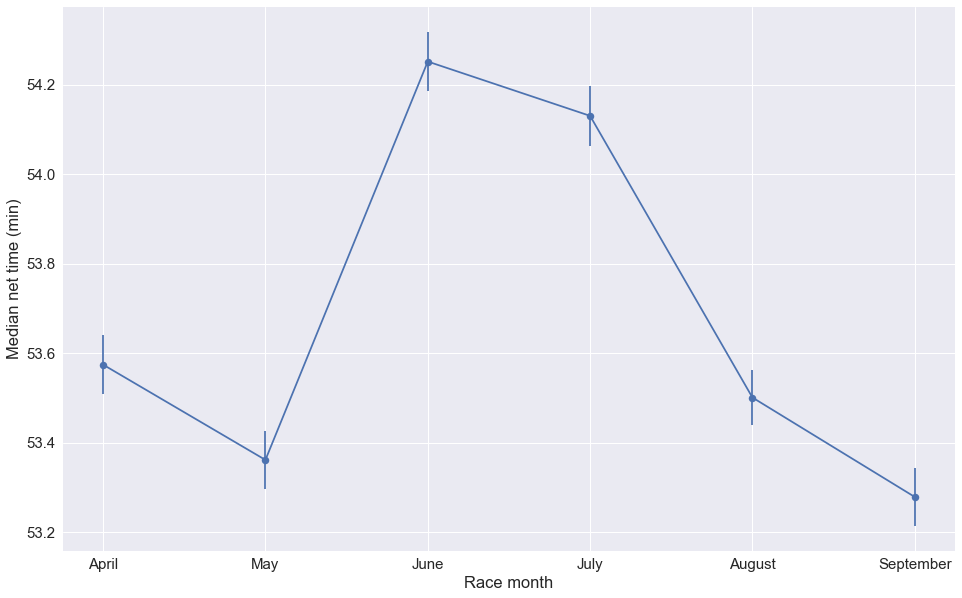

In [61]:
fig, ax = plt.subplots(figsize=(16,10))

n = df2.shape[0]
a = df2.groupby('Race')['Net Time'].mean()
b = df2.groupby('Race')['Net Time'].std() / np.sqrt(n)

plt.errorbar(a.index, a, yerr=b, marker='.',markersize=15)
plt.xlabel('Race month')
plt.ylabel('Median net time (min)')
labels = ['','April','May','June','July','August','September']
ax.set_xticklabels(labels)
plt.savefig('plots/time_seasonality.png')